In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

### Loading Data

In [2]:
with h5py.File("output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("output_bg.h5", "r") as file:
    bg_data = file["events"][:]

In [3]:
feature_names = signal_data.dtype.names

In [4]:
from numpy.lib.recfunctions import structured_to_unstructured
signal_data = structured_to_unstructured(signal_data)
bg_data = structured_to_unstructured(bg_data)

df_signal = pd.DataFrame(signal_data, columns=feature_names)
df_signal['label'] = 1
df_bg = pd.DataFrame(bg_data, columns=feature_names)
df_bg['label'] = 0

data = pd.concat([df_signal, df_bg], ignore_index=True)

In [5]:
data.head()

,jet_1_pt,jet_2_pt,jet_3_pt,jet_1_eta,jet_2_eta,jet_3_eta,jet_1_twb,jet_2_twb,jet_3_twb,bjet_1_pt,lep_1_pt,lep_2_pt,lep_3_pt,n_jets,n_bjets,n_leptons,met_met,H_T,label
0,76.625122,69.155373,59.854385,-1.449552,0.607159,2.389591,1.0,5.0,1.0,69.155373,161.328949,111.039406,78.182617,5.0,2.0,3.0,101.640900,744.554565,1
1,144.411407,132.422119,60.086609,-0.782535,1.503718,-0.931768,5.0,5.0,1.0,144.411407,76.000443,26.815889,19.998375,4.0,2.0,3.0,91.050087,588.856140,1
2,118.343216,80.197807,48.590748,0.247133,-0.409328,-0.136684,5.0,1.0,1.0,118.343216,45.266228,40.032524,10.025892,4.0,1.0,3.0,110.139503,480.372253,1
3,184.577209,130.069366,113.695816,0.053027,0.444536,1.174121,1.0,5.0,1.0,130.069366,66.121330,34.616055,20.493921,5.0,2.0,3.0,76.301582,794.567261,1
4,147.934525,109.259483,47.974209,-1.004912,-0.266024,-1.626755,1.0,1.0,2.0,47.974209,67.392868,45.192726,18.393185,3.0,1.0,3.0,119.359505,555.506531,1


In [6]:
data['n_leptons'].value_counts()

n_leptons
3.0    741538
Name: count, dtype: int64

In [7]:
data = data.drop(columns=['n_leptons']) #dropping n leptons because always = 3

In [8]:
print("Initial")
print(f"Total rows: {data.shape[0]}")

Initial
Total rows: 741538


### Summary Statistics and Plots

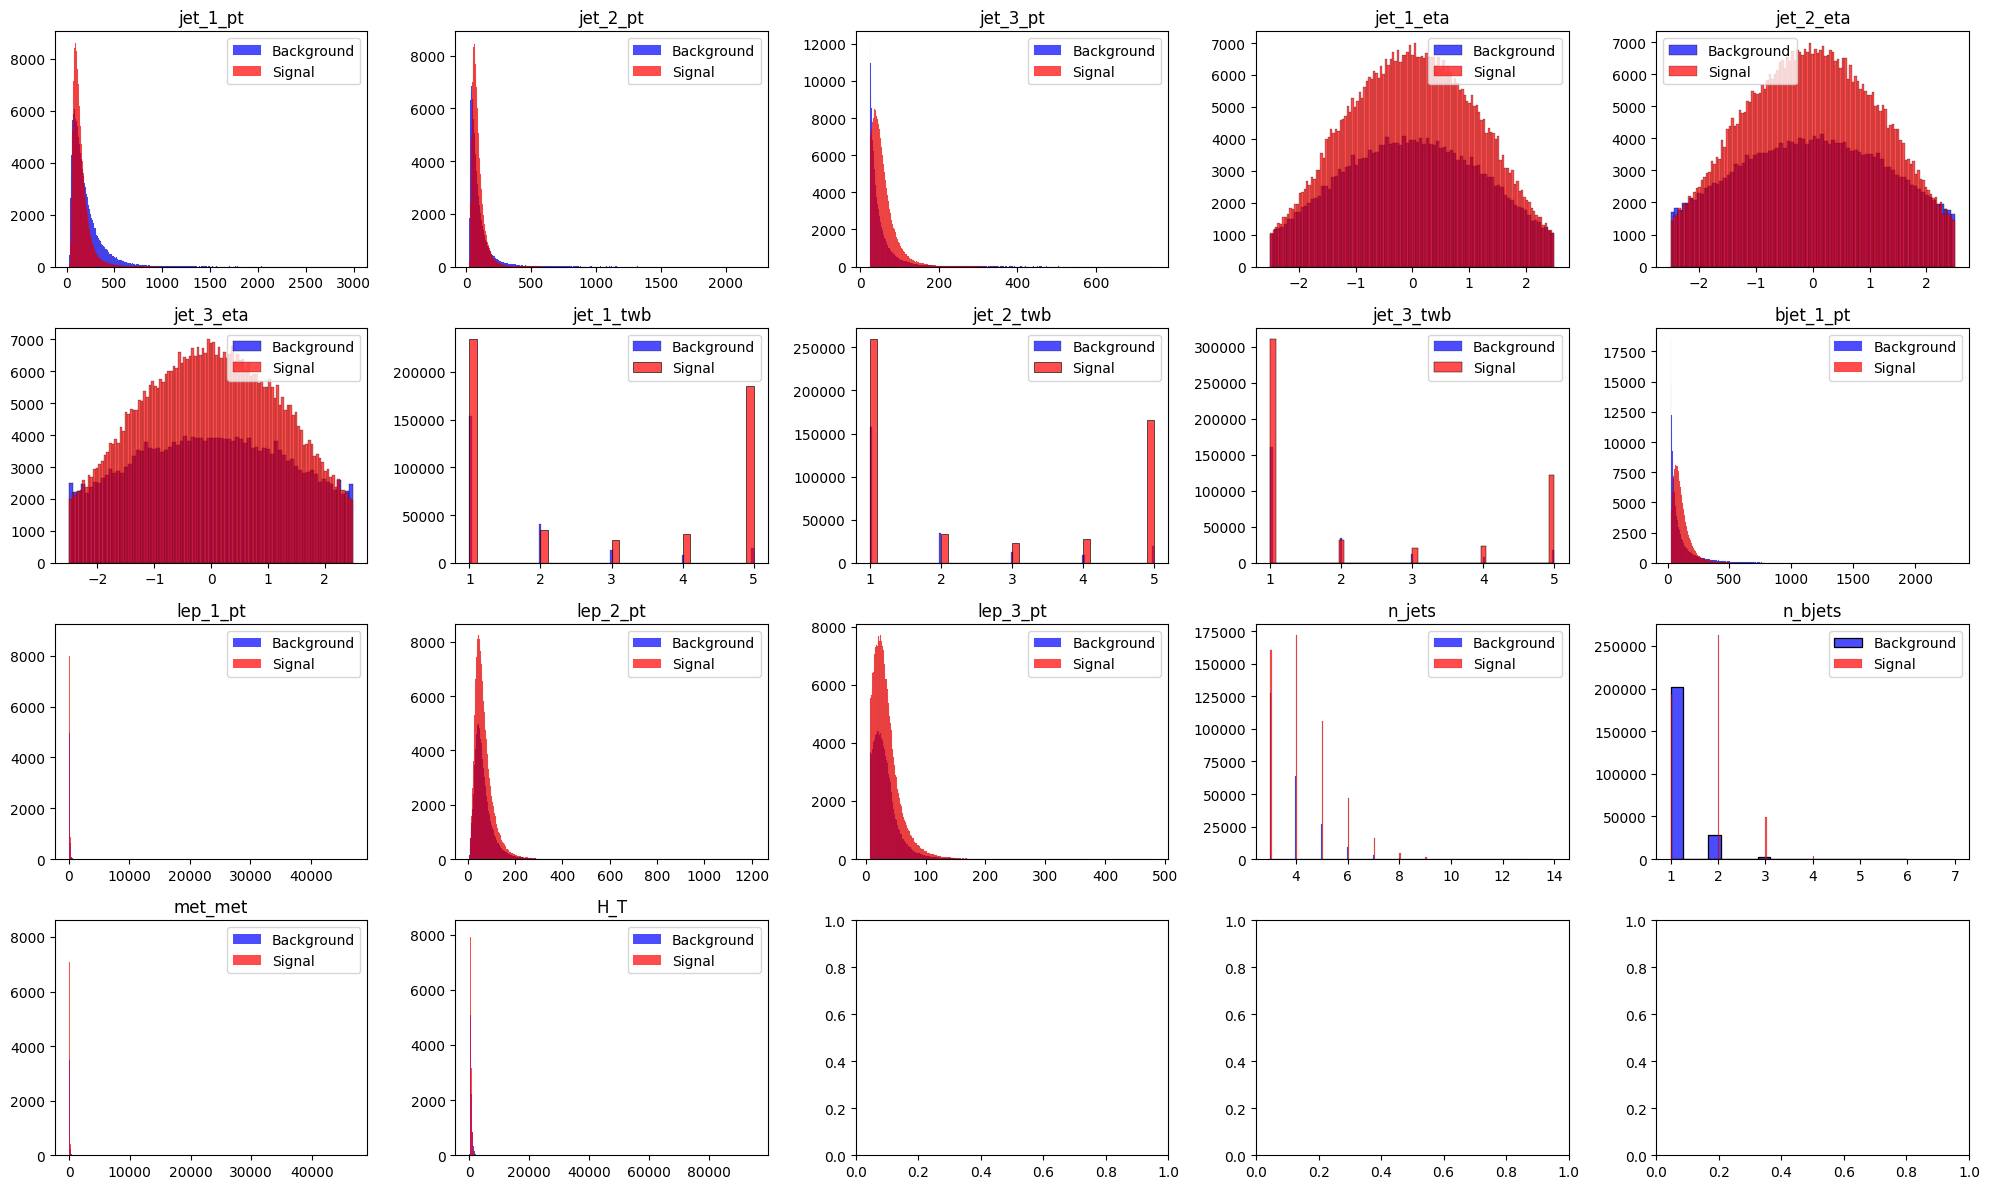

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = 5
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 3*num_rows))

# Flatten the axes array to easily iterate over subplots
axes = axes.flatten()

# Iterate over each feature column
for i, col in enumerate((list(data.columns[:17])+list(data.columns[18:]))):
    # Check if there is data for both labels
    if data[data['label'] == 0][col].nunique() > 0 and data[data['label'] == 1][col].nunique() > 0:
        # Create histograms for each label value
        for label_val, color in zip([0, 1], ['blue', 'red']):
            sns.histplot(data[data['label'] == label_val][col], color=color, ax=axes[i], alpha=0.7)
            axes[i].set_title(col)
            axes[i].set_xlabel('')
            axes[i].set_ylabel('')
            axes[i].legend(['Background', 'Signal'])
    else:
        # Remove the subplot if there is no data
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Histograms show that some features have skewed distributions. So we remove some outliers below.

In [10]:
from scipy.stats import zscore

features = data.drop('label', axis=1)
labels = data['label']

features_zscored = features.apply(zscore)

mask = (features_zscored.abs() < 1.8).all(axis=1)
filtered_features = features[mask]
filtered_labels = labels[mask]

Plots after removing outliers are given below.

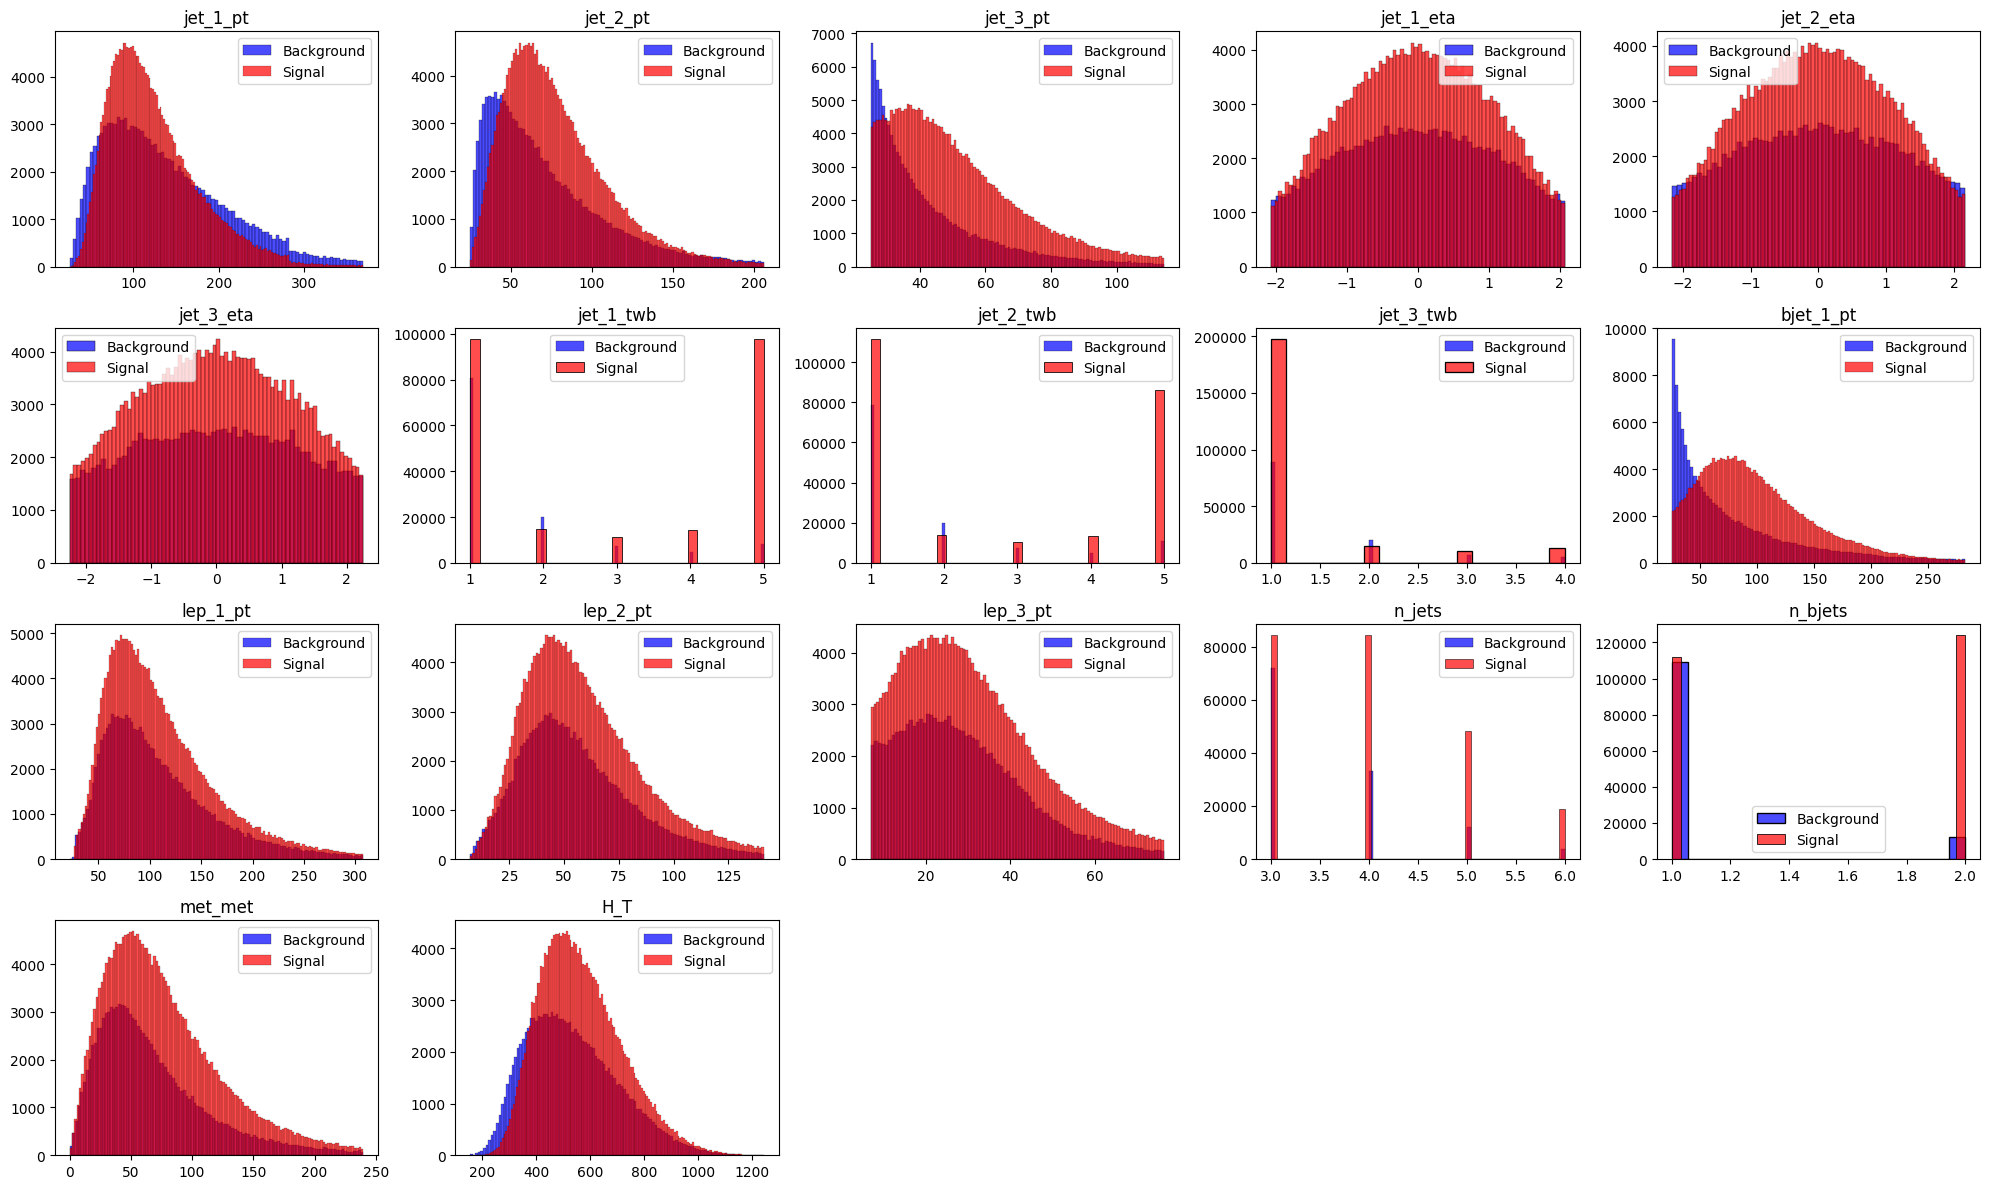

In [11]:
num_features = len(filtered_features.columns)
num_cols = min(num_features, 5)
num_rows = -(-num_features // num_cols)  # Ceiling division to ensure at least 1 row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))

axes = axes.flatten()

# Iterate over each feature column
for i, col in enumerate(filtered_features.columns):
    # Create histograms for each label value
    for label_val, color in zip([0, 1], ['blue', 'red']):
        sns.histplot(filtered_features[filtered_labels == label_val][col], color=color, ax=axes[i], alpha=0.7)
        axes[i].set_title(col)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].legend(['Background', 'Signal'])

# Remove any excess empty subplots
for i in range(num_features, num_cols * num_rows):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('features_histograms', dpi=300)
plt.show()

In [12]:
features_ = filtered_features.copy()
target_ = filtered_labels.copy()
feature_names = features_.columns.tolist()

In [13]:
len(features_.columns.tolist())

17

In [14]:
len(feature_names)

17

In [15]:
features_.describe()

,jet_1_pt,jet_2_pt,jet_3_pt,jet_1_eta,jet_2_eta,jet_3_eta,jet_1_twb,jet_2_twb,jet_3_twb,bjet_1_pt,lep_1_pt,lep_2_pt,lep_3_pt,n_jets,n_bjets,met_met,H_T
count,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000,357071.000000
mean,128.112137,76.121193,48.517708,0.001603,-0.000702,-0.001575,2.551868,2.434272,1.348096,93.173584,109.613136,57.414558,30.126963,3.857364,1.381574,73.342316,555.515259
std,59.352360,33.677902,19.479773,1.035644,1.097827,1.180144,1.772045,1.744674,0.792472,53.104527,52.557693,25.914591,15.326766,0.916560,0.485774,46.221016,159.559845
min,25.377907,25.047926,25.000038,-2.072873,-2.169822,-2.255799,1.000000,1.000000,1.000000,25.000195,22.007652,7.093263,7.000008,3.000000,1.000000,0.010850,154.751999
25%,84.029541,50.974438,33.080343,-0.807422,-0.866331,-0.952769,1.000000,1.000000,1.000000,51.518648,70.573952,38.344259,18.120495,3.000000,1.000000,38.889050,436.813538
50%,115.701859,69.036118,43.568329,-0.001495,-0.001949,-0.002998,2.000000,1.000000,1.000000,82.035721,97.724724,53.071987,27.709476,4.000000,1.000000,63.423153,536.841919
75%,160.299400,94.046730,59.101646,0.812598,0.864235,0.948311,5.000000,5.000000,1.000000,122.182014,136.790184,72.432423,39.437021,4.000000,2.000000,97.791061,656.932709
max,368.953705,206.023087,114.568336,2.074263,2.168227,2.256625,5.000000,5.000000,4.000000,282.502625,307.692352,141.227753,76.464012,6.000000,2.000000,239.812531,1244.341797


No null values detected in any columns.

In [16]:
features = features_
target = target_
features.shape

(357071, 17)

In [17]:
target.shape # checking if feature rows = target rows

(357071,)

### Splitting to Train and Test Sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

### Dummy Classifer

In [19]:
class_counts = y_train.value_counts()
most_frequent_class = class_counts.idxmax()
most_frequent_count = class_counts.max()

print("Most frequent class label:", most_frequent_class)
print("Count of the most frequent class in train set:", most_frequent_count)

Most frequent class label: 1
Count of the most frequent class in train set: 188637


In [20]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)

train_score = dummy_clf.score(X_train, y_train)
test_score = dummy_clf.score(X_test, y_test)

print("Train Accuracy:", train_score)
print("Test Accuracy:", test_score)

Train Accuracy: 0.6603642142997171
Test Accuracy: 0.6615837009031716


The purpose of our model is to distinguish between positive and negative classes in this case. Hence, we will focus on maximizing the AUC (Area under the ROC curve) classification metric which is just the area under the curve of the True Positive Rate vs False Positive Rate. For Dummy Classifier, the AUC is equal to 0.5. Any mention of 'score' below indicates AUC.

### Simple Decision Tree Classifier

Start by testing a decision tree classifier. Simple and does not need scaling.

In [22]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt_pipe = DecisionTreeClassifier(random_state=10)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

cv_scores_pipe = cross_validate(dt_pipe, X_train, y_train, cv=cv, scoring='roc_auc', return_train_score=True)

test_auc = cv_scores_pipe['test_score']
train_auc = cv_scores_pipe['train_score']

scores_df = pd.DataFrame({'Validation Score': test_auc, 'Train Score': train_auc})
scores_df

,Validation Score,Train Score
0,0.713872,1.0
1,0.712673,1.0
2,0.712693,1.0


In [23]:
print(f"Train Mean = {np.mean(cv_scores_pipe['train_score'])}")
print(f"Train Standard deviation = {np.std(cv_scores_pipe['train_score'])}")

print(f"Test Mean = {np.mean(cv_scores_pipe['test_score'])}")
print(f"Test Standard deviation = {np.std(cv_scores_pipe['test_score'])}")

Train Mean = 1.0
Train Standard deviation = 0.0
Test Mean = 0.7130792513283809
Test Standard deviation = 0.0005605995485000548


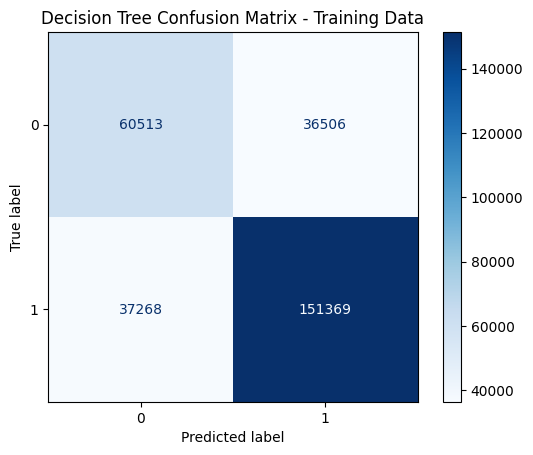

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_dt_train = cross_val_predict(dt_pipe, X_train, y_train, cv=cv)

dt_pipe.fit(X_train, y_train) # fitting to get classes
dt_cf_train = confusion_matrix(y_train, y_pred_dt_train)
dt_cf_train = ConfusionMatrixDisplay(confusion_matrix=dt_cf_train, display_labels=dt_pipe.classes_)
dt_cf_train.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix - Training Data")
plt.savefig('dt_cm_training')
plt.show()

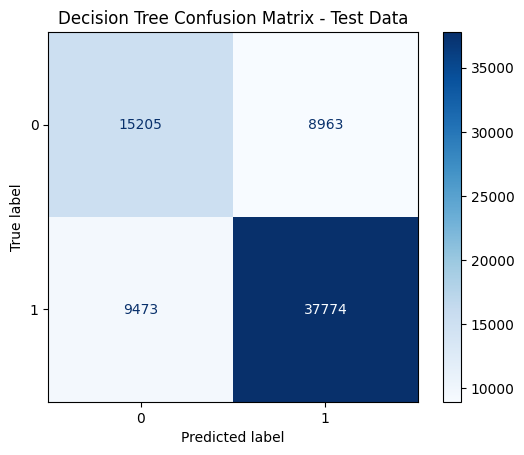

In [25]:
y_pred_dt_test = dt_pipe.predict(X_test)

dt_cf_test = confusion_matrix(y_test, y_pred_dt_test)
dt_cf_display_test = ConfusionMatrixDisplay(confusion_matrix=dt_cf_test, display_labels=dt_pipe.classes_)

dt_cf_display_test.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix - Test Data")
plt.savefig('dt_cm_test')
plt.show()

ROC AUC for DT: 0.7130792767598821


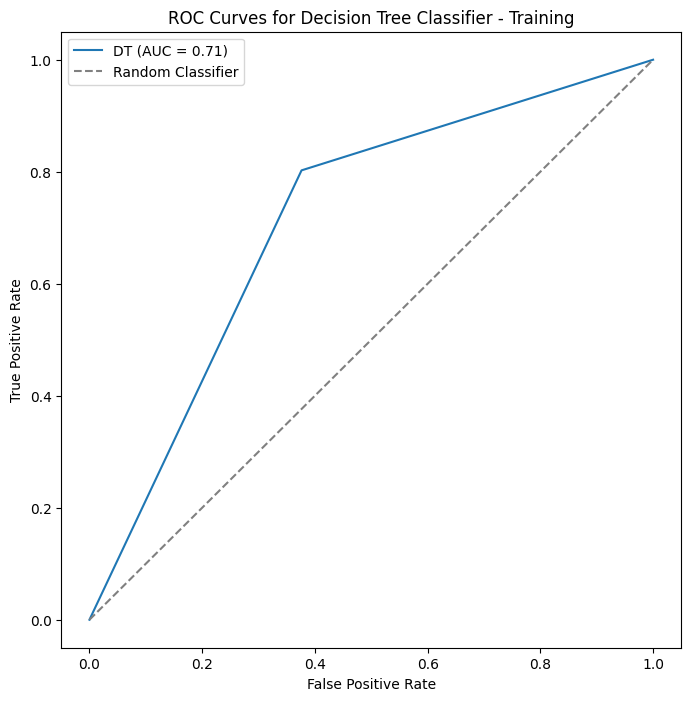

In [26]:
from sklearn.metrics import roc_curve, auc

dt_pipe = DecisionTreeClassifier(random_state=10)
probabilities = cross_val_predict(dt_pipe, X_train, y_train, cv=cv, method='predict_proba')[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_train, probabilities)
auc_dt = auc(fpr_dt, tpr_dt)

print(f"ROC AUC for DT: {auc_dt}")

plt.figure(figsize=(8, 8))
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {auc_dt:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Classifier - Training')
plt.legend()
plt.show()

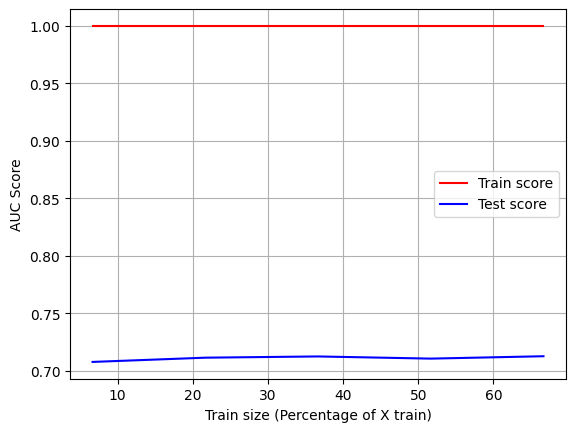

In [27]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(dt_pipe, X_train, y_train, scoring='roc_auc', cv=cv, train_sizes=np.linspace(0.1, 1, 5))

plt.plot((train_sizes/len(X_train))*100, np.mean(train_scores, axis=1), label ='Train score', color='red')
plt.plot((train_sizes/len(X_train))*100, np.mean(test_scores, axis=1), label='Test score', color='blue')
plt.xlabel('Train size (Percentage of X train)')
plt.ylabel('AUC Score')
plt.legend()
plt.grid()
plt.savefig('learning_curve')
plt.show()

From graph above, about 30% of the training set is more than enough to train the model. We assume a similar requirement for the neural network for the future and hence we get 30% of X_train for the training process. Then, we can also get the best hyperparameters and fit the decision tree on the test set obtained in the beginning to see performance.

In [28]:
X_train_positive = X_train[y_train == 1]
X_train_negative = X_train[y_train == 0]

# Calculate the number of samples needed from each class for the reduced dataset
n_samples = int(0.3 * len(X_train))  # 30% of original data size
n_samples_positive = int(n_samples * np.sum(y_train) / len(y_train))  # Maintain class ratio
n_samples_negative = n_samples - n_samples_positive

# Randomly select samples from each class
X_train_subset_positive, _ = train_test_split(X_train_positive, train_size=n_samples_positive, random_state=42)
X_train_subset_negative, _ = train_test_split(X_train_negative, train_size=n_samples_negative, random_state=42)

# Combine the subsets and shuffle
X_train_subset = np.concatenate([X_train_subset_positive, X_train_subset_negative], axis=0)
y_train_subset = np.concatenate([np.ones(n_samples_positive), np.zeros(n_samples_negative)])

# Shuffle the subset data
shuffle_index = np.random.permutation(len(X_train_subset))
X_train_subset = X_train_subset[shuffle_index]
y_train_subset = y_train_subset[shuffle_index]

In [29]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': np.arange(2,7,2),
    'min_samples_leaf': np.arange(2,7,2),
    'criterion': ['gini', 'entropy']
}

dt_classifier = DecisionTreeClassifier(random_state=10)
random_search = RandomizedSearchCV(dt_classifier, param_distributions=param_dist, n_iter=50, cv=cv, scoring='roc_auc', random_state=10,
                                   return_train_score=True)
random_search.fit(X_train_subset, y_train_subset)

print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 7, 'criterion': 'entropy'}


In [30]:
print("Best Score:", random_search.best_score_)

Best Score: 0.8647665635967167


In [31]:
scores_lim = pd.DataFrame(random_search.cv_results_)
scores_lim.sort_values(by='mean_test_score', ascending=False, inplace=True)
scores_lim[['params', 'mean_fit_time', 'mean_test_score', 'std_test_score', 'mean_train_score']].head(10)

,params,mean_fit_time,mean_test_score,std_test_score,mean_train_score
6,"{'min_samples_split': 4, 'min_samples_leaf': 6...",1.088968,0.864767,0.002210,0.876774
22,"{'min_samples_split': 2, 'min_samples_leaf': 6...",1.061296,0.864767,0.002210,0.876774
29,"{'min_samples_split': 4, 'min_samples_leaf': 2...",1.176083,0.864690,0.001985,0.876889
20,"{'min_samples_split': 6, 'min_samples_leaf': 2...",1.081548,0.864690,0.001985,0.876889
9,"{'min_samples_split': 4, 'min_samples_leaf': 4...",1.048854,0.864685,0.002216,0.876821
28,"{'min_samples_split': 2, 'min_samples_leaf': 4...",1.137899,0.864685,0.002216,0.876821
45,"{'min_samples_split': 4, 'min_samples_leaf': 6...",0.737202,0.864308,0.002206,0.875421
2,"{'min_samples_split': 6, 'min_samples_leaf': 6...",0.813106,0.864308,0.002206,0.875421
42,"{'min_samples_split': 4, 'min_samples_leaf': 4...",0.785581,0.864178,0.002416,0.875475
30,"{'min_samples_split': 6, 'min_samples_leaf': 4...",0.837334,0.864178,0.002416,0.875475


In [32]:
pd.set_option('display.max_colwidth', None)
top_5 = scores_lim[['params', 'mean_test_score', 'mean_train_score']].head(5)
top_5

,params,mean_test_score,mean_train_score
6,"{'min_samples_split': 4, 'min_samples_leaf': 6, 'max_depth': 7, 'criterion': 'entropy'}",0.864767,0.876774
22,"{'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 7, 'criterion': 'entropy'}",0.864767,0.876774
29,"{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy'}",0.864690,0.876889
20,"{'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 7, 'criterion': 'entropy'}",0.864690,0.876889
9,"{'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 7, 'criterion': 'entropy'}",0.864685,0.876821


After multiple iterations, sample weights did not affect the scores and hence won't be used going forward to reduce code complexity and save computation.

In [33]:
dt_final = DecisionTreeClassifier(**random_search.best_params_, random_state=10)
dt_final.fit(X_train_subset, y_train_subset)

probabilities_train = dt_final.predict_proba(X_train_subset)[:, 1]

fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train_subset, probabilities_train)
auc_dt_train = auc(fpr_dt_train, tpr_dt_train)

print("ROC AUC Score on Train Set:", auc_dt_train)

probabilities_test = dt_final.predict_proba(X_test.to_numpy())[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, probabilities_test)
auc_dt_test = auc(fpr_dt, tpr_dt)

print("ROC AUC Score on Test Set:", auc_dt_test)

ROC AUC Score on Train Set: 0.875292392995546
ROC AUC Score on Test Set: 0.8662924932622712


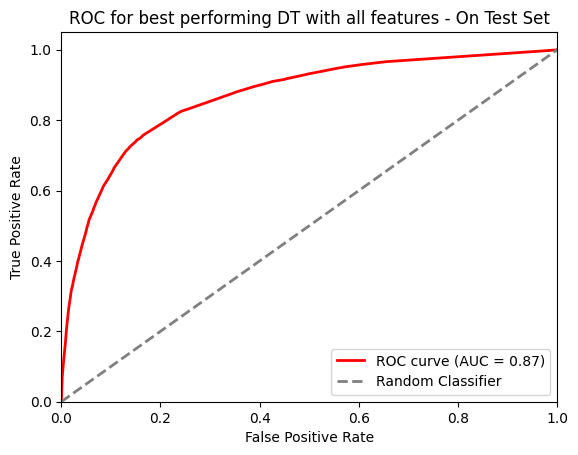

In [34]:
plt.figure()
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % auc_dt_test)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for best performing DT with all features - On Test Set')
plt.legend(loc="lower right")
plt.savefig('roc_dt_all_features-test')
plt.show()

Best performing decision tree on test set is giving the AUC score as above.

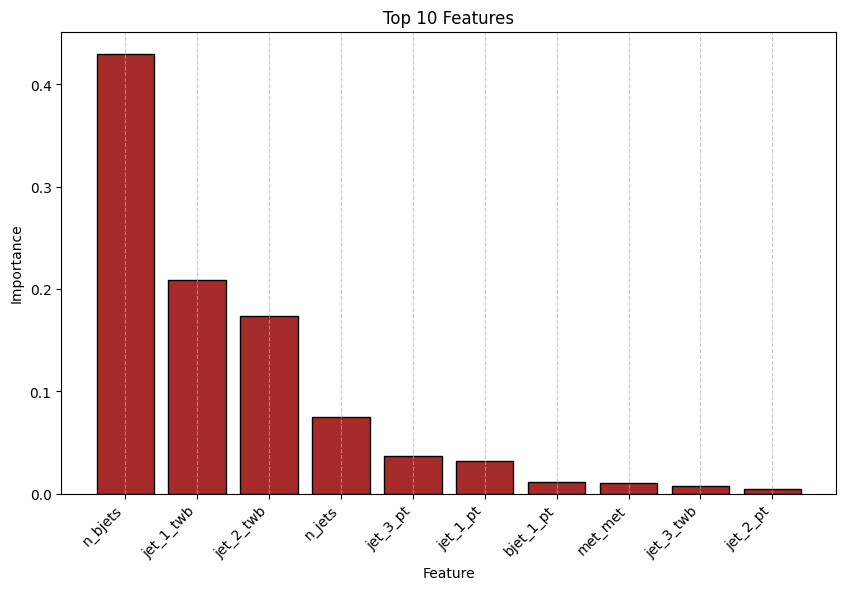

In [35]:
importances = dt_final.feature_importances_

top_10_indices = np.argsort(importances)[::-1][:10]
top_10_features = [feature_names[i] for i in top_10_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[top_10_indices], tick_label=top_10_features, color='brown', edgecolor='black')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('top_10_feats', dpi=300)
plt.show()

In [36]:
# Saving files so I don't have to run everything again.

np.savetxt('X_train_subset.csv', X_train_subset, delimiter=',')
np.savetxt('y_train_subset.csv', y_train_subset, delimiter=',')

In [37]:
X_dt_final = X_train_subset[:, top_10_indices].copy()
Xtest_dt_final = X_test[top_10_features].copy()

dt_optimized = DecisionTreeClassifier(criterion='gini', min_samples_split=6, min_samples_leaf=2, max_depth=7, random_state=10)
dt_optimized.fit(X_dt_final, y_train_subset)

probabilities_train = dt_optimized.predict_proba(X_dt_final)[:, 1]

fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train_subset, probabilities_train)
auc_dt_train = auc(fpr_dt_train, tpr_dt_train)

print("ROC AUC Score on Train Set:", auc_dt_train)

probabilities_test = dt_optimized.predict_proba(Xtest_dt_final.to_numpy())[:, 1]

fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, probabilities_test)
auc_dt_test = auc(fpr_dt_test, tpr_dt_test)

print("ROC AUC Score on Test Set:", auc_dt_test)

ROC AUC Score on Train Set: 0.8733413737263483
ROC AUC Score on Test Set: 0.8665716675617983


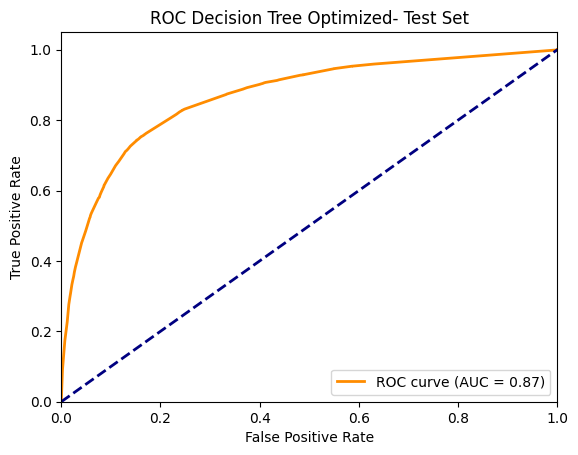

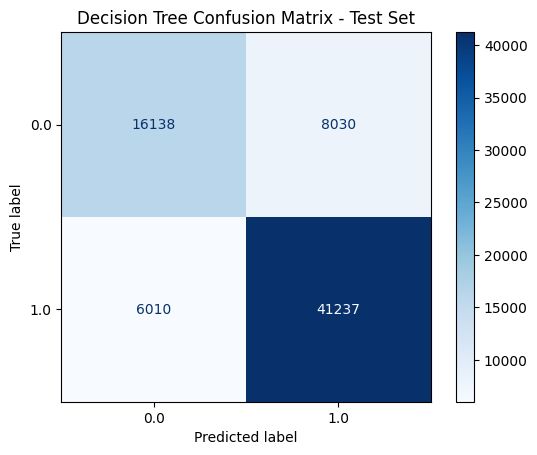

In [38]:
plt.figure()
plt.plot(fpr_dt_test, tpr_dt_test, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_dt_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree Optimized- Test Set')
plt.legend(loc="lower right")
plt.show()

y_pred_test = dt_optimized.predict(Xtest_dt_final.to_numpy())
dt_cf_test = confusion_matrix(y_test, y_pred_test)
dt_cf_display_test = ConfusionMatrixDisplay(confusion_matrix=dt_cf_test, display_labels=dt_optimized.classes_)

dt_cf_display_test.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix - Test Set")
plt.savefig('dt_cm_optimized')
plt.show()

Not much improvement here by removing features.

### DT on full data

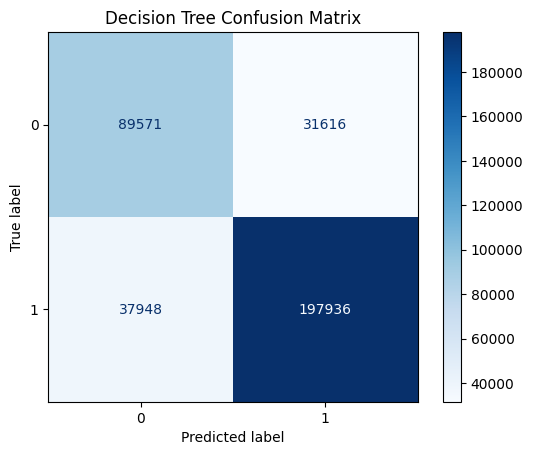

ROC AUC for DT: 0.8692533843671557


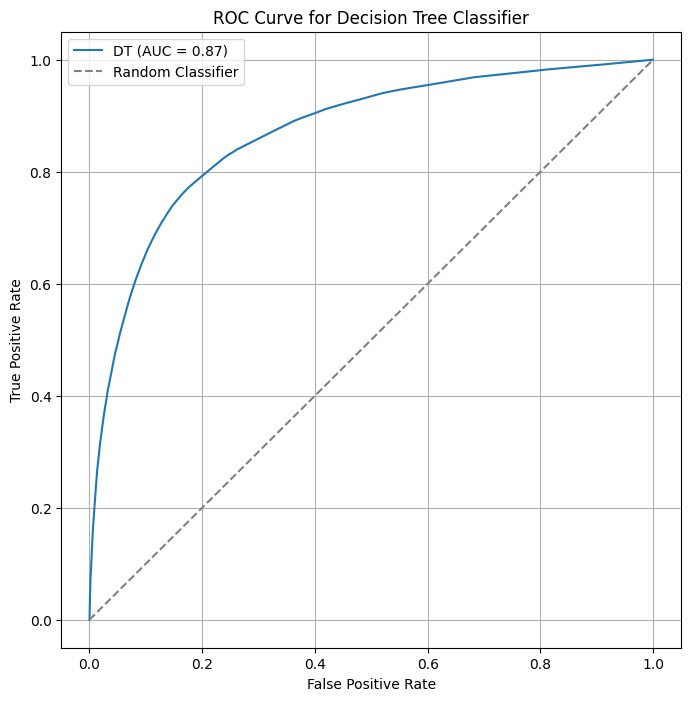

In [39]:
## Importing again because testing model on data directly without cross validation for double checking that there is no data leakage
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

dt_data = DecisionTreeClassifier(min_samples_split=6, min_samples_leaf=2, max_depth=7, criterion='entropy', random_state=10)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
y_pred_dt_data= cross_val_predict(dt_data, features, target, cv=cv)

dt_data.fit(features, target) # fitting to get classes
dt_cf = confusion_matrix(target, y_pred_dt_data)
dt_cf = ConfusionMatrixDisplay(confusion_matrix=dt_cf, display_labels=dt_data.classes_)
dt_cf.plot(cmap='Blues', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.savefig('dt_cm_full', dpi=300)
plt.show()

probabilities = cross_val_predict(dt_data, features, target, cv=cv, method='predict_proba')[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(target, probabilities)
auc_dt = auc(fpr_dt, tpr_dt)

print(f"ROC AUC for DT: {auc_dt}")

plt.figure(figsize=(8, 8))
plt.plot(fpr_dt, tpr_dt, label=f'DT (AUC = {auc_dt:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.grid()
plt.legend()
plt.savefig('dt_roc_full', dpi=300)
plt.show()

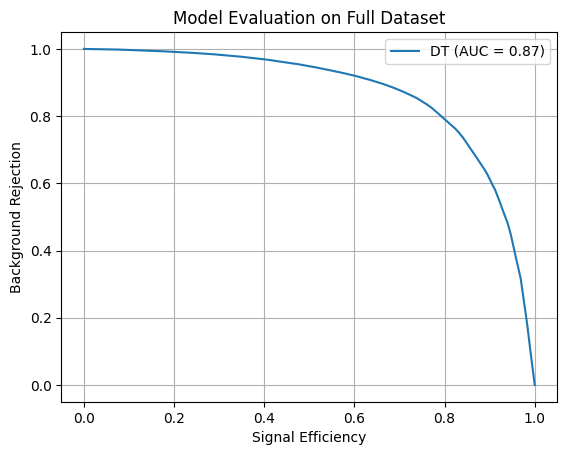

In [40]:
plt.plot(tpr_dt, 1-fpr_dt, label=f'DT (AUC = {auc_dt:.2f})')

plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Model Evaluation on Full Dataset')
plt.grid()
plt.legend()
plt.savefig('dt_eval_full', dpi=300)
plt.show()

### Neural Network

In [41]:
X_nn = X_train_subset[:, top_10_indices].copy()
Xtest_nn = X_test[top_10_features].copy()

In [42]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_nn, y_train_subset, random_state=10)

train_ratio = 0.8
val_ratio = 0.2

train_size = int(len(X_shuffled) * train_ratio)
val_size = int(len(X_shuffled) * val_ratio)

X_train, X_val = X_shuffled[:train_size], X_shuffled[train_size:train_size + val_size]
y_train, y_val = y_shuffled[:train_size], y_shuffled[train_size:train_size + val_size]

# Print shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (68556, 10)
X_val shape: (17139, 10)
y_train shape: (68556,)
y_val shape: (17139,)


In [43]:
nn_scaler = StandardScaler()

X_train_scaled = nn_scaler.fit_transform(X_train)
X_val_scaled = nn_scaler.transform(X_val)
X_test_scaled = nn_scaler.transform(Xtest_nn.to_numpy())

In [44]:
import tensorflow as tf
import keras as K

from keras.models import Sequential #the model is built adding layers one after the other
from keras.layers import Dense, Input #fully connected layers: every output talks to every input
from keras.layers import Dropout #for regularization
from keras.callbacks import LearningRateScheduler

In [45]:
tf.keras.backend.clear_session()

Will build a simple model first.

In [46]:
model = Sequential()
model.add(Input(shape=(10, )))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['auc'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661 (2.58 KB)

 Trainable params: 661 (2.58 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
def time_based_decay(epoch):
    initial_lr = 1e-3
    total_epochs = 100
    new_lr = initial_lr / (1 + (epoch * initial_lr / total_epochs))
    return new_lr

In [48]:
from keras.callbacks import EarlyStopping

epochs = 50
batch_size = 128

early_stopping = EarlyStopping(monitor='val_auc', mode='max', min_delta=0.002, patience=50)
lr_scheduler = LearningRateScheduler(time_based_decay, verbose=1)

history = model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_scaled, y_val), callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc: 0.7978 - loss: 0.5110 - val_auc: 0.8753 - val_loss: 0.4183 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009999900000999989.
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - auc: 0.8770 - loss: 0.4109 - val_auc: 0.8791 - val_loss: 0.4123 - learning_rate: 9.9999e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999980000399992.
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8810 - loss: 0.4060 - val_auc: 0.8802 - val_loss: 0.4121 - learning_rate: 9.9998e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000999970000899973.
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8833 - loss: 0.4011 - val_auc: 0.8809 - val_loss: 0.4093 - learning_rate: 9.9997e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000999960001599936.
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━

In [49]:
history.history.keys()

dict_keys(['auc', 'loss', 'val_auc', 'val_loss', 'learning_rate'])

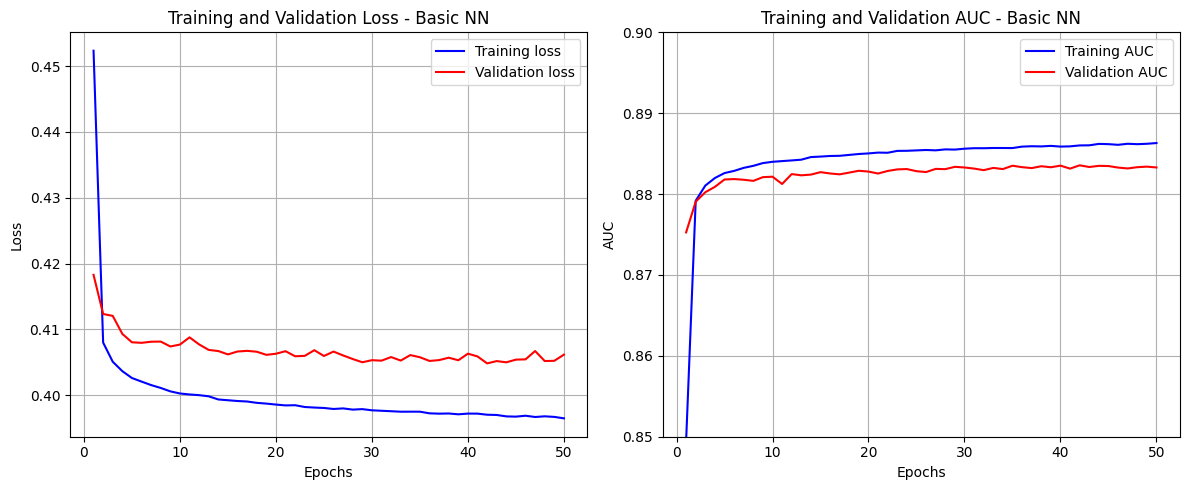

In [50]:
train_auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(train_auc) + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Basic NN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and Validation AUC - Basic NN')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.ylim(0.85, 0.9)
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('basic_nn_loss+auc')
plt.show()

Not seeing a lot of overfitting so will not worry too much about regularization.

In [51]:
scores = model.evaluate(X_test_scaled, y_test, verbose=1)
print("Test Accuracy:", scores[1])

2232/2232 ━━━━━━━━━━━━━━━━━━━━ 2s 887us/step - auc: 0.8855 - loss: 0.3978
Test Accuracy: 0.8844362497329712


2232/2232 ━━━━━━━━━━━━━━━━━━━━ 2s 838us/step
AUC Score: 0.8844545772140575


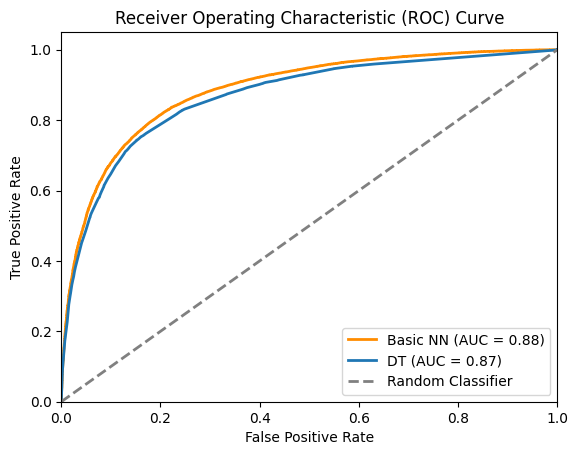

In [52]:
y_pred_prob = model.predict(X_test_scaled)

fpr_nn_1, tpr_nn_1, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_nn = auc(fpr_nn_1, tpr_nn_1)
print("AUC Score:", roc_auc_nn)

plt.figure()
plt.plot(fpr_nn_1, tpr_nn_1, color='darkorange', lw=2, label='Basic NN (AUC = %0.2f)' % roc_auc_nn)
plt.plot(fpr_dt_test, tpr_dt_test, label=f'DT (AUC = {auc_dt_test:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', label='Random Classifier', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Optimizing hyperparameters

In [53]:
def train_model(optimizer):
    model = Sequential([
        Input(shape=(10,)),
        Dense(20, activation='relu'),
        Dense(20, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['auc'])

    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, 
                        validation_data=(X_val_scaled, y_val), verbose=0)
    
    return history

In [54]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam

optimizers = ['SGD', SGD(momentum=0.5), RMSprop(), Adagrad(), Adam()]
histories = []

for optimizer in optimizers:
    history = train_model(optimizer)
    histories.append(history)

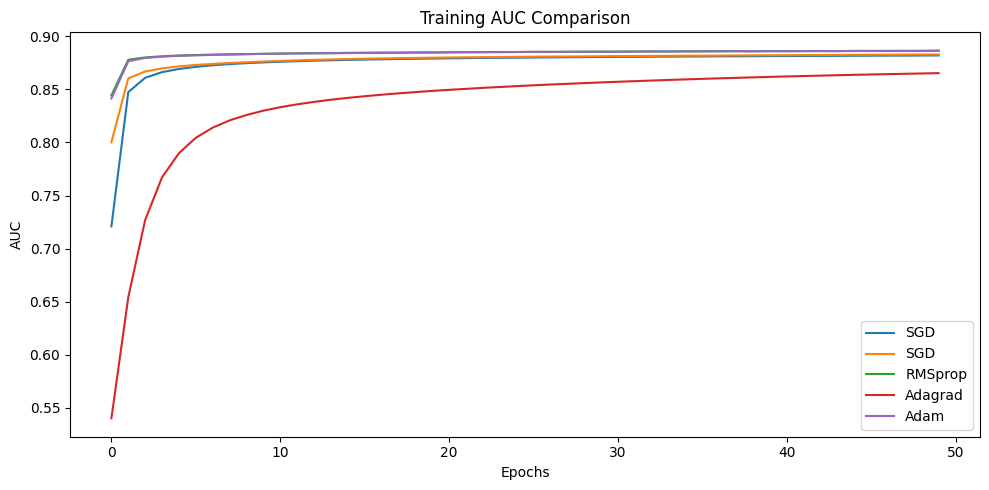

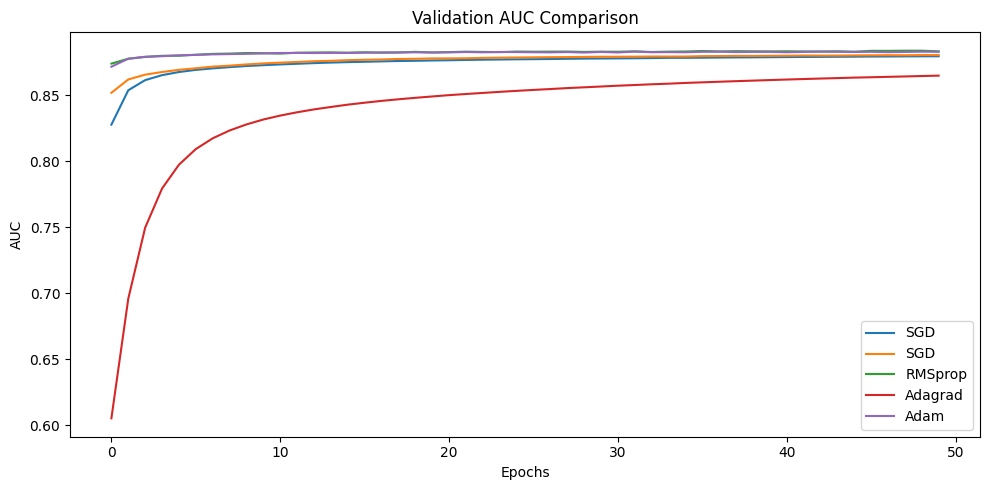

In [55]:
optimizer_labels = []
for optimizer in optimizers:
    if isinstance(optimizer, str):
        optimizer_labels.append(optimizer)
    else:
        optimizer_labels.append(optimizer.__class__.__name__)

plt.figure(figsize=(10, 5))
for i, optimizer in enumerate(optimizers):
    plt.plot(histories[i].history['auc'], label=optimizer_labels[i])
plt.title('Training AUC Comparison')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, optimizer in enumerate(optimizers):
    plt.plot(histories[i].history['val_auc'], label=optimizer_labels[i])
plt.title('Validation AUC Comparison')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.show()

Adam and RMSProp are doing the best job, so we'll stick to Adam.

In [56]:
def build_model(hp):
    model = Sequential()
    
    # Number of layers
    for i in range(hp.Int('num_layers', 1, 2)):
        # Neurons in each layer
        model.add(Dense(units=hp.Int('units_' + str(i),
                                     min_value=50, max_value=650, step=200), 
                        activation=hp.Choice('activation_' + str(i), ['relu', 'tanh'])))
    
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    # Fixed optimizer and learning rate
    optimizer = Adam(learning_rate=1e-3)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['auc'])  # AUC as metric for binary classification
    
    return model

After multiple iterations, best performing models had 1 or 2 layers and 1e-3 learning rate. Above function is representative of that.

In [57]:
tf.keras.backend.clear_session()

In [58]:
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(build_model, objective='val_loss', max_trials=20, executions_per_trial=1, project_name='final_project')
tuner.search(X_train_scaled, y_train, epochs=50, validation_data = (X_val_scaled, y_val), batch_size=128, verbose=0)

Reloading Tuner from .\final_project\tuner0.json


In [59]:
tuner.results_summary(5)

Results summary
Results in .\final_project
Showing 5 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
num_layers: 2
units_0: 450
activation_0: relu
units_1: 450
activation_1: tanh
Score: 0.4007572531700134

Trial 15 summary
Hyperparameters:
num_layers: 1
units_0: 450
activation_0: relu
units_1: 450
activation_1: relu
Score: 0.40141624212265015

Trial 16 summary
Hyperparameters:
num_layers: 1
units_0: 650
activation_0: relu
units_1: 650
activation_1: relu
Score: 0.40151622891426086

Trial 08 summary
Hyperparameters:
num_layers: 1
units_0: 450
activation_0: relu
units_1: 50
activation_1: tanh
Score: 0.40168726444244385

Trial 03 summary
Hyperparameters:
num_layers: 2
units_0: 50
activation_0: tanh
units_1: 450
activation_1: tanh
Score: 0.40180128812789917


In [60]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'num_layers': 2,
 'units_0': 450,
 'activation_0': 'relu',
 'units_1': 450,
 'activation_1': 'tanh'}

In [61]:
best_model = tuner.hypermodel.build(best_hps)
best_model.build(input_shape=(None,10))
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 450)            │         4,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 450)            │       202,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,351 (813.87 KB)

 Trainable params: 208,351 (813.87 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
best_model_history = best_model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, 
                                        validation_data=(X_val_scaled, y_val), callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - auc: 0.8694 - loss: 0.4220 - val_auc: 0.8805 - val_loss: 0.4123 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009999900000999989.
Epoch 2/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc: 0.8796 - loss: 0.4066 - val_auc: 0.8811 - val_loss: 0.4106 - learning_rate: 9.9999e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000999980000399992.
Epoch 3/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - auc: 0.8860 - loss: 0.3976 - val_auc: 0.8810 - val_loss: 0.4110 - learning_rate: 9.9998e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000999970000899973.
Epoch 4/50
536/536 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - auc: 0.8823 - loss: 0.4028 - val_auc: 0.8823 - val_loss: 0.4110 - learning_rate: 9.9997e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000999960001599936.
Epoch 5/50
536/536 ━━━━━━━━━━━━━━━━━━━━

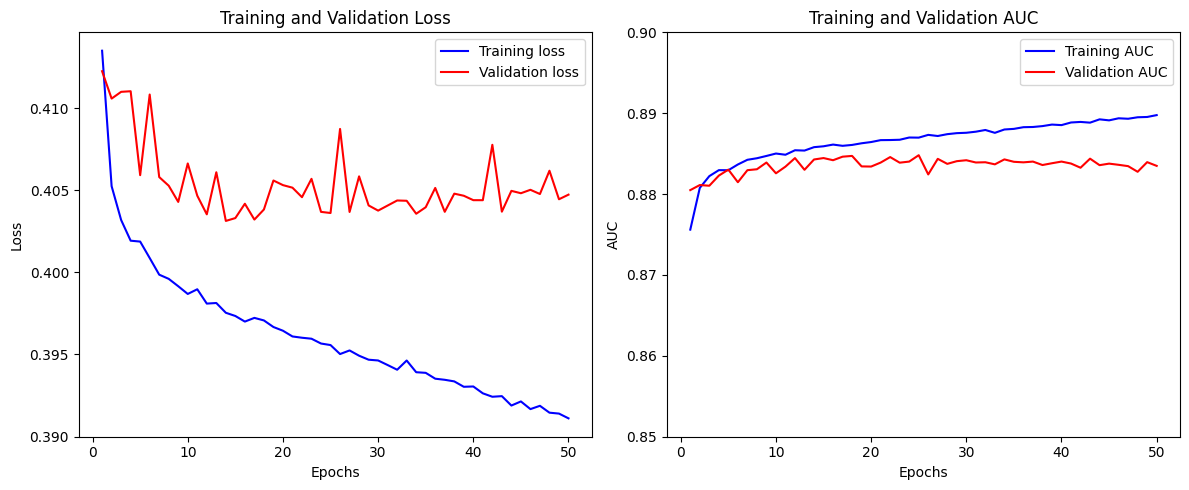

In [63]:
train_auc = best_model_history.history['auc']
val_auc = best_model_history.history['val_auc']

epochs = range(1, len(train_auc) + 1)

train_loss = best_model_history.history['loss']
val_loss = best_model_history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.ylim(0.85, 0.9)
plt.legend()

plt.tight_layout()
plt.savefig('best_nn.png', dpi=300)
plt.show()

### Final Evaluation

2232/2232 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
AUC Score: 0.8842833954937193


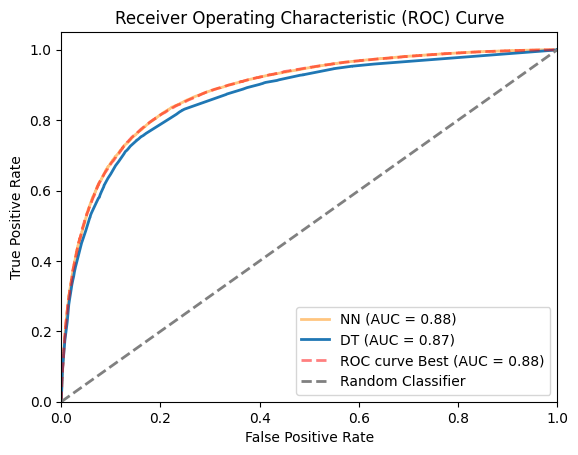

In [64]:
y_pred_prob_best = best_model.predict(X_test_scaled)

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best)
auc_nn_best = auc(fpr_best, tpr_best)
print("AUC Score:", auc_nn_best)

plt.figure()
plt.plot(fpr_nn_1, tpr_nn_1, color='darkorange', lw=2, label='NN (AUC = %0.2f)' % roc_auc_nn, alpha=0.5)
plt.plot(fpr_dt_test, tpr_dt_test, label=f'DT (AUC = {auc_dt_test:.2f})', lw=2)
plt.plot(fpr_best, tpr_best, color='r', lw=2, label='ROC curve Best (AUC = %0.2f)' % auc_nn_best, alpha=0.5, linestyle='--')
plt.plot([0, 1], [0, 1], color='gray', label='Random Classifier', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

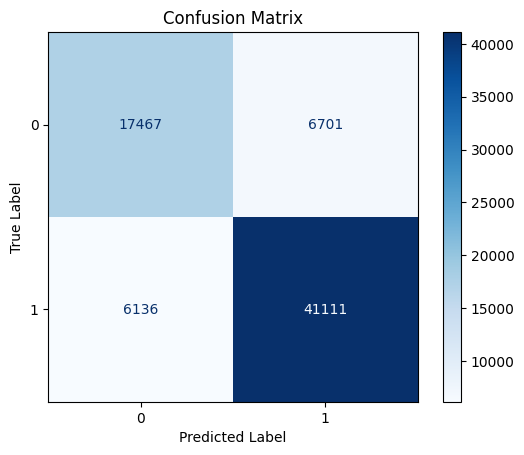

In [65]:
y_pred_best = (y_pred_prob_best > 0.5).astype(int)

conf_matrix_best = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_best, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('best_nn_cm', dpi=300)
plt.show()

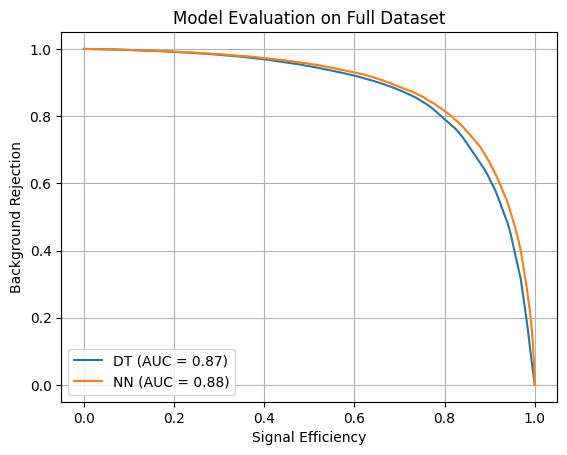

In [66]:
plt.plot(tpr_dt, 1-fpr_dt, label=f'DT (AUC = {auc_dt:.2f})')
plt.plot(tpr_best, 1-fpr_best, label=f'NN (AUC = {auc_nn_best:.2f})')

plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Model Evaluation on Full Dataset')
plt.grid()
plt.legend()
plt.savefig('both_eval_full', dpi=300)
plt.show()

### Neural Network Cross Validation

In [67]:
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate,KFold

In [68]:
def create_single_model():
    model = Sequential()
    model.add(Dense(450, activation='relu'))
    model.add(Dense(450, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['auc'])
    model.build(input_shape=(None,17))
    return model

In [69]:
estimator = KerasClassifier(model=create_single_model(), epochs=50, batch_size=200, verbose=0)

In [70]:
pipe = Pipeline([('scale', StandardScaler()), ('model', estimator)])
cv = KFold(n_splits=3, shuffle=True, random_state=10)
scores = cross_validate(pipe, features, target, cv = cv, scoring='roc_auc', return_train_score=True)
scores

c:\Users\mahen\Desktop\310\project\.conda\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
print(f"Mean AUC Test: {np.mean(scores['test_score'])}")

Mean AUC Test: 0.8846915686884383


In [ ]:
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,246.930545,1.352636,0.883262,0.909536
1,211.818989,1.371461,0.886032,0.908779
2,305.067437,2.115934,0.884780,0.910085
